<a href="https://colab.research.google.com/github/mamikah/DeepLearning2022Late/blob/main/MNISTExample1004~.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNISTデータセットを使って手書き数字の画像判定を実装する

## ライブラリをimport

In [1]:
#学習用ライブラリ
from tensorflow import keras
#MNISTデータセットを読み込む
from tensorflow.keras.datasets import mnist
#学習モデルSequentialモデル
from tensorflow.keras.models import Sequential
#ニューロンの各層
from tensorflow.keras.layers import Dense, Dropout,Activation
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping,CSVLogger

#表示用にpyplotを読み込む
%matplotlib inline
import matplotlib.pyplot as plt

## ハイパーパラメータの定義

In [2]:
# バッチサイズ（元のデータを何件ごとまとめて処理するか）
batch_size = 128
# クラス数（結果をいくつに分類するか）
num_classes = 10
# エポックサイズ(学習の回数：順伝播逆伝播の繰り返し数)
epochs = 20

## MNISTデータセットを読み込む

In [3]:
# MNISTデータ読込
# x_**は画像データ y_**は答え(その画像が数字の何なのか)
# **_trainは学習用データ **_testは検証用データ
(x_train,y_train),(x_test,y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


## MNISTデータをいくつか表示

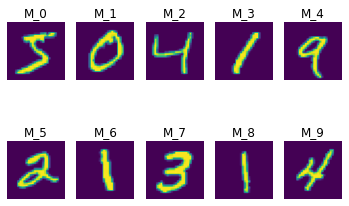

In [4]:
# ループしてx_trainに入ったMNISTの画像データを試しに表示
# pyplotで表示
for i in range(10):
  plt.subplot(2, 5, i+1) # 2行5列で、i+1番目の画像をプロットセット
  plt.title("M_%d" % i) # 「M_0」のような形式でタイトルを表示
  plt.axis("off") # 軸線をオフ
  plt.imshow(x_train[i].reshape(28,28), cmap=None)

## データの前処理（画像サイズを正規化）

データを1文字分1行（1レコード）の形にする

In [5]:
# 28*28 の画像を1行にすると、784ピクセルになる
# 横に784個、0～255までのRGB色数値が並ぶようにする

# x_trainは6万字（6万行）分＊784列の2次元配列に変換することになる
x_train = x_train.reshape(60000,784).astype('float32')

# x_testは1万字（1万行）分＊784列の2次元配列に変換することになる
x_test = x_test.reshape(10000, 784).astype('float32')

# 画像度との色情報（RGB　0～255）を0～1の小数値の範囲に変換する
x_train /= 255 # 255で割った値で上書き
x_test /= 255

# 答えデータをnum_classesの数（10）に分類
y_train = keras.utils.to_categorical(y_train,num_classes) # 学習用
y_test = keras.utils.to_categorical(y_test,num_classes)   # 検証用


## 変換したデータの形を表示して確認

In [6]:
# 学習　xデータ
print(x_train.shape)  # 60000行(60000文字レコード) 784列
print(x_test.shape)   # 10000行(10000字レコード) 784列
print(y_train.shape)  # 60000行(60000文字レコード) (num_class:0∼9の分類)
print(y_test.shape)   # 10000行(10000文字レコード) (num_class:0∼9の分類)

(60000, 784)
(10000, 784)
(60000, 10)
(10000, 10)


## 学習モデルを組み立てる
生成した学習モデルのインスタンスに層を追加していく

In [7]:
# 学習モデルを生成
model = Sequential()

In [8]:
# ニューラル層を作っていく
# 784次元のデータが、任意の数だけ入力され、512次元の形で出力される
model.add(Dense(512, input_shape=(784,)))
# 活性化関数をrelu関数に指定
model.add(Activation('relu'))
# Dropout（データを間引いて過学習を防ぐ）
model.add(Dropout(0.2)) # 20％の結果値を0にリセット

## 2層目を追加する

In [9]:
# ニューロンの層の追加
model.add(Dense(512))   # 512の次元で出カされる
# 活性化関数をreluに指定
model.add(Activation('relu'))
# Dropout（データを間引いて過学習を防ぐ）
model.add(Dropout(0.2)) # 20％の結果値を0にリセット

## 学習モデルに3層目（最後の層）を追加する

In [10]:
# ニューロンの3層目（出力層）の追加
# 最後は10個に分類
model.add(Dense(num_classes))
# 最後だけ活性化関数はsoftmaxを指定する
# 複数の出力値の合計が「1.0」= 100%になるような値を返してくれるから
model.add(Activation('softmax'))


## 組み立てた学習モデルの要約（サマリ・概要）を表示

In [11]:
# 学習モデルのサマリ
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5

## 学習モデルが動く形になるようにコンパイルする

In [12]:
# モデルをコンパイル
model.compile(
    loss='categorical_crossentropy',   # 損失の基準（交差エントロピー誤差）
    optimizer=RMSprop(),
    metrics=['accuracy']  # accuracy＝精度
)

## 学習モデルに学習させる

In [13]:
# コールバック処理の準備
# 学習が進んで損失がそれ以上下がらなければ早期終了する
# patience=2 は2回学習分だけ、終了まで様子を見る
es = EarlyStopping(monitor='val_loss', patience=2)
# ログ出力
csv_logger = CSVLogger('training.log')
# 学習モデルに学習させる
# 正解データにフィットするように重みを調整する
hist = model.fit(
    x_train,  # 学習用画像データ:問題
    y_train,  # 学習用画像データ:正解
    batch_size = batch_size, # バッチサイズ
    epochs = epochs,  # エポック数（学習回数）
    verbose = 1,   # 進行状況を表示
    validation_split = 0.1,   # validationデータ（学習中の検証データ）の割合(10%は学習に使わず、検証チェックに使う)
    callbacks=[es,csv_logger] # コールバック処理
)

Epoch 1/20
422/422 [==============================] - 17s 37ms/step - loss: 0.2628 - accuracy: 0.9195 - val_loss: 0.0958 - val_accuracy: 0.9720
Epoch 2/20
422/422 [==============================] - 8s 19ms/step - loss: 0.1098 - accuracy: 0.9666 - val_loss: 0.0742 - val_accuracy: 0.9768
Epoch 3/20
422/422 [==============================] - 8s 20ms/step - loss: 0.0774 - accuracy: 0.9769 - val_loss: 0.0696 - val_accuracy: 0.9793
Epoch 4/20
422/422 [==============================] - 8s 19ms/step - loss: 0.0606 - accuracy: 0.9818 - val_loss: 0.0765 - val_accuracy: 0.9802
Epoch 5/20
422/422 [==============================] - 8s 19ms/step - loss: 0.0521 - accuracy: 0.9842 - val_loss: 0.0679 - val_accuracy: 0.9828
Epoch 6/20
422/422 [==============================] - 13s 30ms/step - loss: 0.0428 - accuracy: 0.9869 - val_loss: 0.0706 - val_accuracy: 0.9848
Epoch 7/20
422/422 [==============================] - 12s 29ms/step - loss: 0.0387 - accuracy: 0.9883 - val_loss: 0.0809 - val_accuracy: 0.9

## 学習済みのモデルを使って、学習結果をテスト検証する

In [14]:
# evaluateメソッドで検証する
score = model.evaluate(x_test,y_test,verbose=0) # 検証結果を変数に代入
print('test loss:', score[0])  # 損失（誤り値）を表示
print('test acc:', score[1]) # 精度（正解率）を表示

test loss: 0.07365827262401581
test acc: 0.9821000099182129


## 学習履歴をグラフ表示する

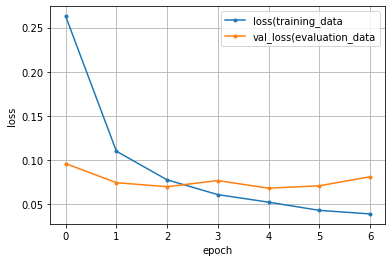

In [16]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss(training_data')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss(evaluation_data')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()